In [1]:
get_ipython().magic('matplotlib notebook')
get_ipython().magic('load_ext autoreload')
get_ipython().magic('autoreload 2')

import matplotlib.pyplot as plt
import sys
import os
import tripyview as tpv
import numpy as np 
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

/tmp/ipykernel_32511/3416496725.py:1: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('matplotlib notebook')
/tmp/ipykernel_32511/3416496725.py:2: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('load_ext autoreload')
/tmp/ipykernel_32511/3416496725.py:3: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('autoreload 2')
/home/pscholz/Software/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(


/home/pscholz/Python/tripyview


/home/pscholz/Software/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(


In [2]:
def plot_anomalie_spiral(time, data, nmon, cinfo, 
                         rmin=4, rmax=20, rexp=1.0, drw=1.2, yrpercircl=20, 
                         ticklen=0.25, do_barscal=False):
    
    #_______________________________________________________________________________
    if nmon==1:
        year = time.copy()
        nyr  = len(year)
    else:
        year = np.unique(np.floor(time))
        nyr  = len(year)
    nt   = len(time)
    
    #_______________________________________________________________________________
    # build spiral coordinates
    dyr      = year[-1]-year[0]+1

    # one spiral circle should correspond to a decade, how many spiral circles
    #i need to cover the whole period?
    nspcirc  = dyr/yrpercircl

    # 1decade=2pi°, 1year = 2pi/10
    phi_shift= yrpercircl-np.mod(year[0],yrpercircl)

    phi      = np.linspace(0,nspcirc*2*np.pi,nt+1)-(phi_shift*2*np.pi/yrpercircl) - np.pi/2
    # phi = phi - (phi(2)-phi(1))/2; % center upwards

    r        = np.linspace(rmin, rmax, nt+1)**rexp
    dr       = np.ones((nt+1,))*drw
    if do_barscal: dr = dr*2

    xr , yr  =  r * np.cos(-phi)      , r * np.sin(-phi)
    xrl, yrl = (r-dr/2) * np.cos(-phi), (r-dr/2) * np.sin(-phi)
    xru, yru = (r+dr/2) * np.cos(-phi), (r+dr/2) * np.sin(-phi)

    #_______________________________________________________________________________
    fig, ax1 = plt.subplots(figsize=[12,12])
    ax1.set_aspect('equal', 'box')

    #_______________________________________________________________________________
    # construct lines for single year position 
    phi_yr     = np.linspace(0,2*np.pi, yrpercircl+1)-(phi_shift*2*np.pi/yrpercircl) - np.pi/2;
    phi_yr     = phi_yr[0:-2];
    auxr       = np.array([(rmin-drw/2)**rexp, rmax**rexp+1])
    auxr       = auxr[:,np.newaxis]
    x_yr, y_yr = auxr * np.cos(-phi_yr), auxr * np.sin(-phi_yr);
    hlyr       = ax1.plot(x_yr, y_yr, color='k', linewidth=0.2, zorder=0)

    #_______________________________________________________________________________
    # construct labels for single year position and label for monthly 
    x_yrl, y_yrl = (rmax**rexp+2) * np.cos(-phi_yr), (rmax**rexp+2) * np.sin(-phi_yr)
    for ii, (x,y) in enumerate(zip(x_yrl, y_yrl)):
        ax1.text(x,y,'{:2d}'.format(ii+1), verticalalignment='center', horizontalalignment='center')

    if (nmon!=1):
        monthlabels = ['Jan.','Feb.','Mar.','Apr.','May ','June','July','Aug.','Oct.','Sep.','Nov.','Dec.'];
        phi_mon    = np.linspace(phi_yr[0],phi_yr[1],13);
        phi_mon    = (phi_mon[1:]+phi_mon[:-1])/2;
        x_monlable = (rmax**rexp+0.1)*np.cos(-phi_mon);
        y_monlable = (rmax**rexp+0.1)*np.sin(-phi_mon);
        for ii in range(0,len(phi_mon)):
            rvec = [x_monlable[ii], y_monlable[ii]];
            rvec = rvec/np.sqrt(rvec[0]**2 + rvec[1]**2);
            angl = np.arctan2(rvec[1],rvec[0])*180/np.pi + 180;
            if (angl>90 and angl<270): angl = angl-180 ;
            ax1.text(x_monlable[ii], y_monlable[ii],monthlabels[ii],
                     verticalalignment='bottom', horizontalalignment='left', 
                     rotation=angl, fontsize=6)
    
    #_______________________________________________________________________________
    # construct spiral line and faces
    xlline = [];
    ylline = [];
    npts = 25;
    patches = list()
    def wght(a, npts): return a[0]+np.linspace(0,1,npts)*np.diff(a)
    if do_barscal:
        scal = data.copy().squeeze()
        scal[scal>cinfo['clevel'][-1]] = cinfo['clevel'][-1]
        scal[scal<cinfo['clevel'][ 0]] = cinfo['clevel'][ 0]
        scal[scal>cinfo['cref']] = scal[scal>cinfo['cref']]/cinfo['clevel'][-1]
        scal[scal<cinfo['cref']] = scal[scal<cinfo['cref']]/cinfo['clevel'][ 0] * np.sign(cinfo['clevel'][0])
        
    for ii in range(0, nt):
        if (do_barscal):
            if (scal[ii]>cinfo['cref']):
                aux_xl  = (wght(r[[ii,ii+1]],npts)                                    )*np.cos(-wght(phi[[ii,ii+1]],npts));
                aux_yl  = (wght(r[[ii,ii+1]],npts)                                    )*np.sin(-wght(phi[[ii,ii+1]],npts));
                aux_xu  = (wght(r[[ii,ii+1]],npts)+wght(dr[[ii,ii+1]],npts)/2*scal[ii])*np.cos(-wght(phi[[ii,ii+1]],npts));
                aux_yu  = (wght(r[[ii,ii+1]],npts)+wght(dr[[ii,ii+1]],npts)/2*scal[ii])*np.sin(-wght(phi[[ii,ii+1]],npts));
            else:
                aux_xl  = (wght(r[[ii,ii+1]],npts)+wght(dr[[ii,ii+1]],npts)/2*scal[ii])*np.cos(-wght(phi[[ii,ii+1]],npts));
                aux_yl  = (wght(r[[ii,ii+1]],npts)+wght(dr[[ii,ii+1]],npts)/2*scal[ii])*np.sin(-wght(phi[[ii,ii+1]],npts));
                aux_xu  = (wght(r[[ii,ii+1]],npts)                                    )*np.cos(-wght(phi[[ii,ii+1]],npts));
                aux_yu  = (wght(r[[ii,ii+1]],npts)                                    )*np.sin(-wght(phi[[ii,ii+1]],npts));
            aux_xlline  = (wght(r[[ii,ii+1]],npts)                                    )*np.cos(-wght(phi[[ii,ii+1]],npts));
            aux_ylline  = (wght(r[[ii,ii+1]],npts)                                    )*np.sin(-wght(phi[[ii,ii+1]],npts));
        else:
            aux_xl      = (wght(r[[ii,ii+1]],npts)-wght(dr[[ii,ii+1]],npts)/2         )*np.cos(-wght(phi[[ii,ii+1]],npts));
            aux_yl      = (wght(r[[ii,ii+1]],npts)-wght(dr[[ii,ii+1]],npts)/2         )*np.sin(-wght(phi[[ii,ii+1]],npts));
            aux_xu      = (wght(r[[ii,ii+1]],npts)+wght(dr[[ii,ii+1]],npts)/2         )*np.cos(-wght(phi[[ii,ii+1]],npts));
            aux_yu      = (wght(r[[ii,ii+1]],npts)+wght(dr[[ii,ii+1]],npts)/2         )*np.sin(-wght(phi[[ii,ii+1]],npts));
            aux_xlline  = (wght(r[[ii,ii+1]],npts)-wght(dr[[ii,ii+1]],npts)/2         )*np.cos(-wght(phi[[ii,ii+1]],npts));
            aux_ylline  = (wght(r[[ii,ii+1]],npts)-wght(dr[[ii,ii+1]],npts)/2         )*np.sin(-wght(phi[[ii,ii+1]],npts));    
        aux_xc  = np.hstack(( aux_xl, np.flip(aux_xu) ))
        aux_yc  = np.hstack(( aux_yl, np.flip(aux_yu) ))
        polygon = Polygon(np.vstack((aux_xc,aux_yc)).transpose(), closed=True)
        patches.append(polygon)
        xlline  = np.hstack(( xlline, aux_xlline))
        ylline  = np.hstack(( ylline, aux_ylline))

    hlsp = ax1.plot(xlline, ylline, color='k', linewidth=1.0, zorder=2)
    p    = PatchCollection(patches, cmap=cinfo['cmap'], edgecolor='none', zorder=1)
    p.set_array(data.squeeze())
    p.set_clim([cinfo['clevel'][0], cinfo['clevel'][-1]])
    hp   = ax1.add_collection(p)

    #_______________________________________________________________________________
    # construct spiral labels
    tlabel  = np.hstack((year[0],np.arange(1880,2020,yrpercircl), year[-1] ));
    tlabel2 = np.hstack((year[0],np.arange(1880,2020,yrpercircl/4), year[-1] ));
    for ii in range(0,nt):
        if (np.any(time[ii] in tlabel)):
            rvec  = [xrl[ii], yrl[ii]];
            rvec  = rvec/np.sqrt(rvec[0]**2 + rvec[1]**2);
            nvec  = [-rvec[1], rvec[0]];
            angl  = np.arctan2(nvec[1],nvec[0])*180/np.pi + 180;
            if (angl>90 and angl<270): angl = angl-180 ;

            if do_barscal:
                xtl,ytl = (r[ii]-ticklen*2)*np.cos(-phi[ii]), (r[ii]-ticklen*2)*np.sin(-phi[ii])
                plt.plot([xr[ii],xtl], [yr[ii], ytl], color='k', linewidth=1.0)
                xtl,ytl = (r[ii]-ticklen*2.5*2)*np.cos(-phi[ii]), (r[ii]-ticklen*2.5*2)*np.sin(-phi[ii])
                ax1.text(xtl, ytl, '{:4d}'.format(time[ii].astype(int)) ,  
                     verticalalignment='center', horizontalalignment='center', 
                     rotation=angl, fontweight='bold', fontsize=10)
            else:    
                xtl,ytl = (r[ii]-dr[ii]/2-ticklen)*np.cos(-phi[ii]), (r[ii]-dr[ii]/2-ticklen)*np.sin(-phi[ii])
                plt.plot([xrl[ii],xtl], [yrl[ii], ytl], color='k', linewidth=1.0)
                xtl,ytl = (r[ii]-dr[ii]/2-ticklen*2.5)*np.cos(-phi[ii]), (r[ii]-dr[ii]/2-ticklen*2.5)*np.sin(-phi[ii])
                ax1.text(xtl, ytl, '{:4d}'.format(time[ii].astype(int)) ,  
                     verticalalignment='center', horizontalalignment='center', 
                     rotation=angl, fontweight='bold', fontsize=10)
        elif (np.any(time[ii] in tlabel2)):
            rvec  = [xrl[ii], yrl[ii]];
            rvec  = rvec/np.sqrt(rvec[0]**2 + rvec[1]**2);
            nvec  = [-rvec[1], rvec[0]];
            angl  = np.arctan2(nvec[1],nvec[0])*180/np.pi + 180;
            if (angl>90.1and angl<269.5): angl = angl-180 ;
            if do_barscal:
                xtl,ytl = (r[ii]-ticklen*2)*np.cos(-phi[ii]), (r[ii]-ticklen*2)*np.sin(-phi[ii])
                plt.plot([xr[ii],xtl], [yr[ii], ytl], color='k', linewidth=1.0)
                xtl,ytl = (r[ii]-ticklen*2.5*2)*np.cos(-phi[ii]), (r[ii]-ticklen*2.5*2)*np.sin(-phi[ii])
                ax1.text(xtl, ytl, '{:4d}'.format(time[ii].astype(int)) ,  
                     verticalalignment='center', horizontalalignment='center', 
                     rotation=angl, fontweight='normal', fontsize=8)
            else:    
                xtl,ytl = (r[ii]-dr[ii]/2-ticklen)*np.cos(-phi[ii]), (r[ii]-dr[ii]/2-ticklen)*np.sin(-phi[ii])
                plt.plot([xrl[ii],xtl], [yrl[ii], ytl], color='k', linewidth=1.0)
                xtl,ytl = (r[ii]-dr[ii]/2-ticklen*2.5)*np.cos(-phi[ii]), (r[ii]-dr[ii]/2-ticklen*2.5)*np.sin(-phi[ii])
                ax1.text(xtl, ytl, '{:4d}'.format(time[ii].astype(int)) ,  
                     verticalalignment='center', horizontalalignment='center', 
                     rotation=angl, fontweight='normal', fontsize=8)        

    #_______________________________________________________________________________
    # add and arrange colorbar
    divider = make_axes_locatable(ax1)
    cax     = divider.append_axes("right", size="2.5%", pad=0.1)
    cbar    = plt.colorbar(hp, ax=ax1, cax=cax, orientation='vertical', ticks=cinfo['clevel'], 
                        extendrect=False, extendfrac=None, drawedges=True,)  

    # arange colorbar labels
    cfac=2
    idcref = np.where(cinfo['clevel']==cinfo['cref'])[0][0]
    cblkeep = np.sort(np.unique(np.hstack((cinfo['clevel'][range(idcref,0-1,-cfac)], cinfo['clevel'][range(idcref,len(cinfo['clevel']),cfac)] )) ))
    if cbar.orientation=='vertical': tickl = cbar.ax.get_yticklabels()
    else:                            tickl = cbar.ax.get_xticklabels()
    for ii in range(0,len(cinfo['clevel'])): 
        if cinfo['clevel'][ii] in cblkeep:    
            if (cinfo['clevel'][ii]>=0): tickl[ii] = ' {:2.2f}'.format(cinfo['clevel'][ii])
            else              : tickl[ii] = '{:2.2f}'.format(cinfo['clevel'][ii])
    if cbar.orientation=='vertical': cbar.ax.set_yticklabels(tickl)
    else:                            cbar.ax.set_xticklabels(tickl)
    cbar.set_label('Temperature anomalie / $^\circ$C', size=12)    

    #_______________________________________________________________________________
    # arange axes labels
    ax1.axis('off')
    plt.show()

    return(fig, ax1)

In [3]:
#_______________________________________________________________________________
dname = '/home/pscholz/AWI/AWI_MATLAB/MONICA_scipts/plot_climatestribes/' 
fname = 'ger-att.prn' 
sel_yr     = [1881, 2018]  
sel_refyr  = [1971, 2000]

# load data
data = np.loadtxt(os.path.join(dname,fname))
year    = data[:, 0   ];
data_mm = data[:, 1:13];
data_ym = data[:, -1  ];

# select years 
idx_selyr = (year>=sel_yr[0]) & (year<=sel_yr[1]) 
year      = year[idx_selyr]
data_mm   = data_mm[idx_selyr,:]
data_ym   = data_ym[idx_selyr]
nyr       = len(year)

# compute annual anomalies
idx_selyr = (year>=sel_refyr[0]) & (year<=sel_refyr[1]) 
data_anom1= data_ym - np.sum(data_ym[idx_selyr])/np.sum(idx_selyr)
data_anom1= data_anom1[np.newaxis,:]
time1     = year 

# compute monthly anomalies    
nmon = 12
time_yr   = year[:, np.newaxis] * np.ones((1,nmon))
time_yr   = time_yr.flatten()
time_mon  = np.ones((nyr,1)) + np.arange(0,nmon,1)
time_mon  = time_mon.flatten()
time2     = time_yr + (time_mon-1)/nmon
    
idx_selyr = (year>=sel_refyr[0]) & (year<=sel_refyr[1]) 
data_clim = np.sum(data_mm[idx_selyr,:], axis=0)/np.sum(idx_selyr)
data_clim = np.ones((nyr,1))*data_clim[np.newaxis,:]
data_clim = data_clim.flatten()
data_anom2 = data_mm.flatten() - data_clim
data_anom2 = data_anom2[np.newaxis,:]
    

<IPython.core.display.Javascript object>


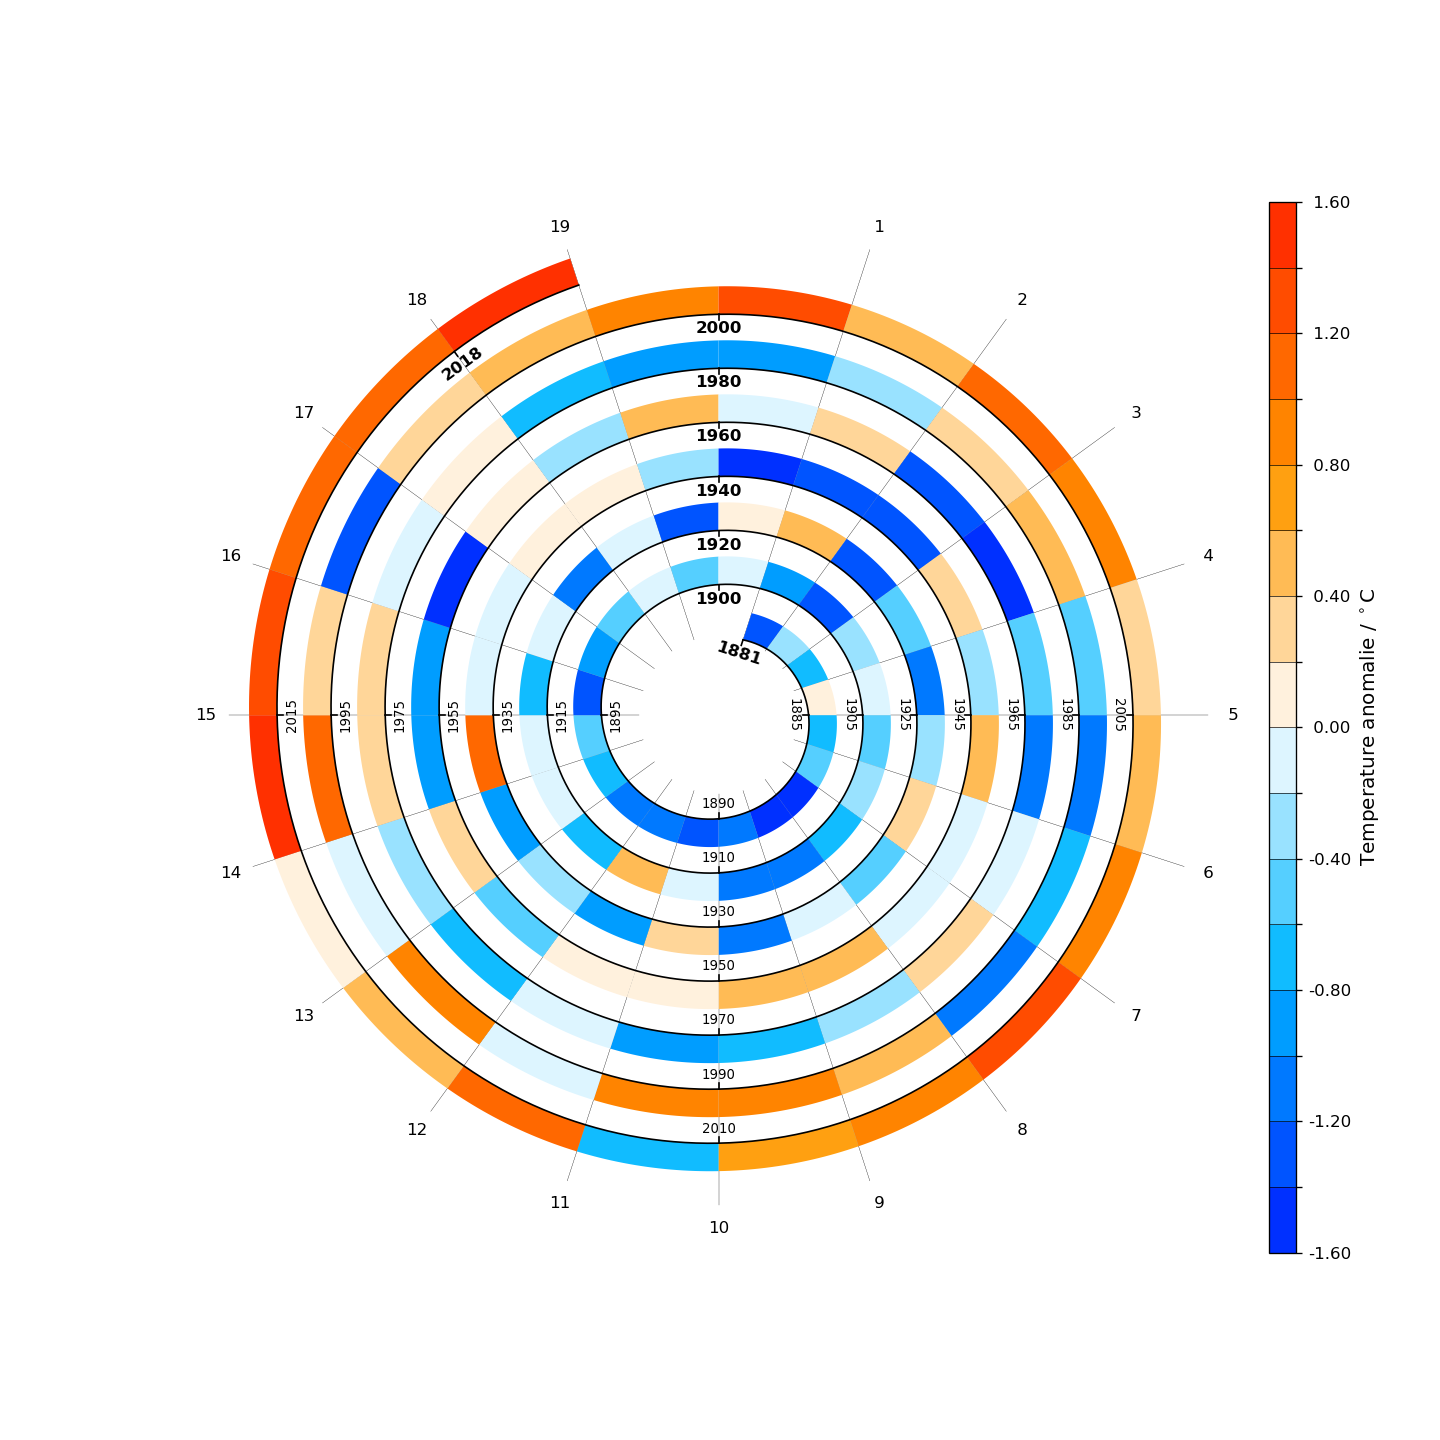

 > save figure: ./anomaly_spiral_ym.png


<IPython.core.display.Javascript object>


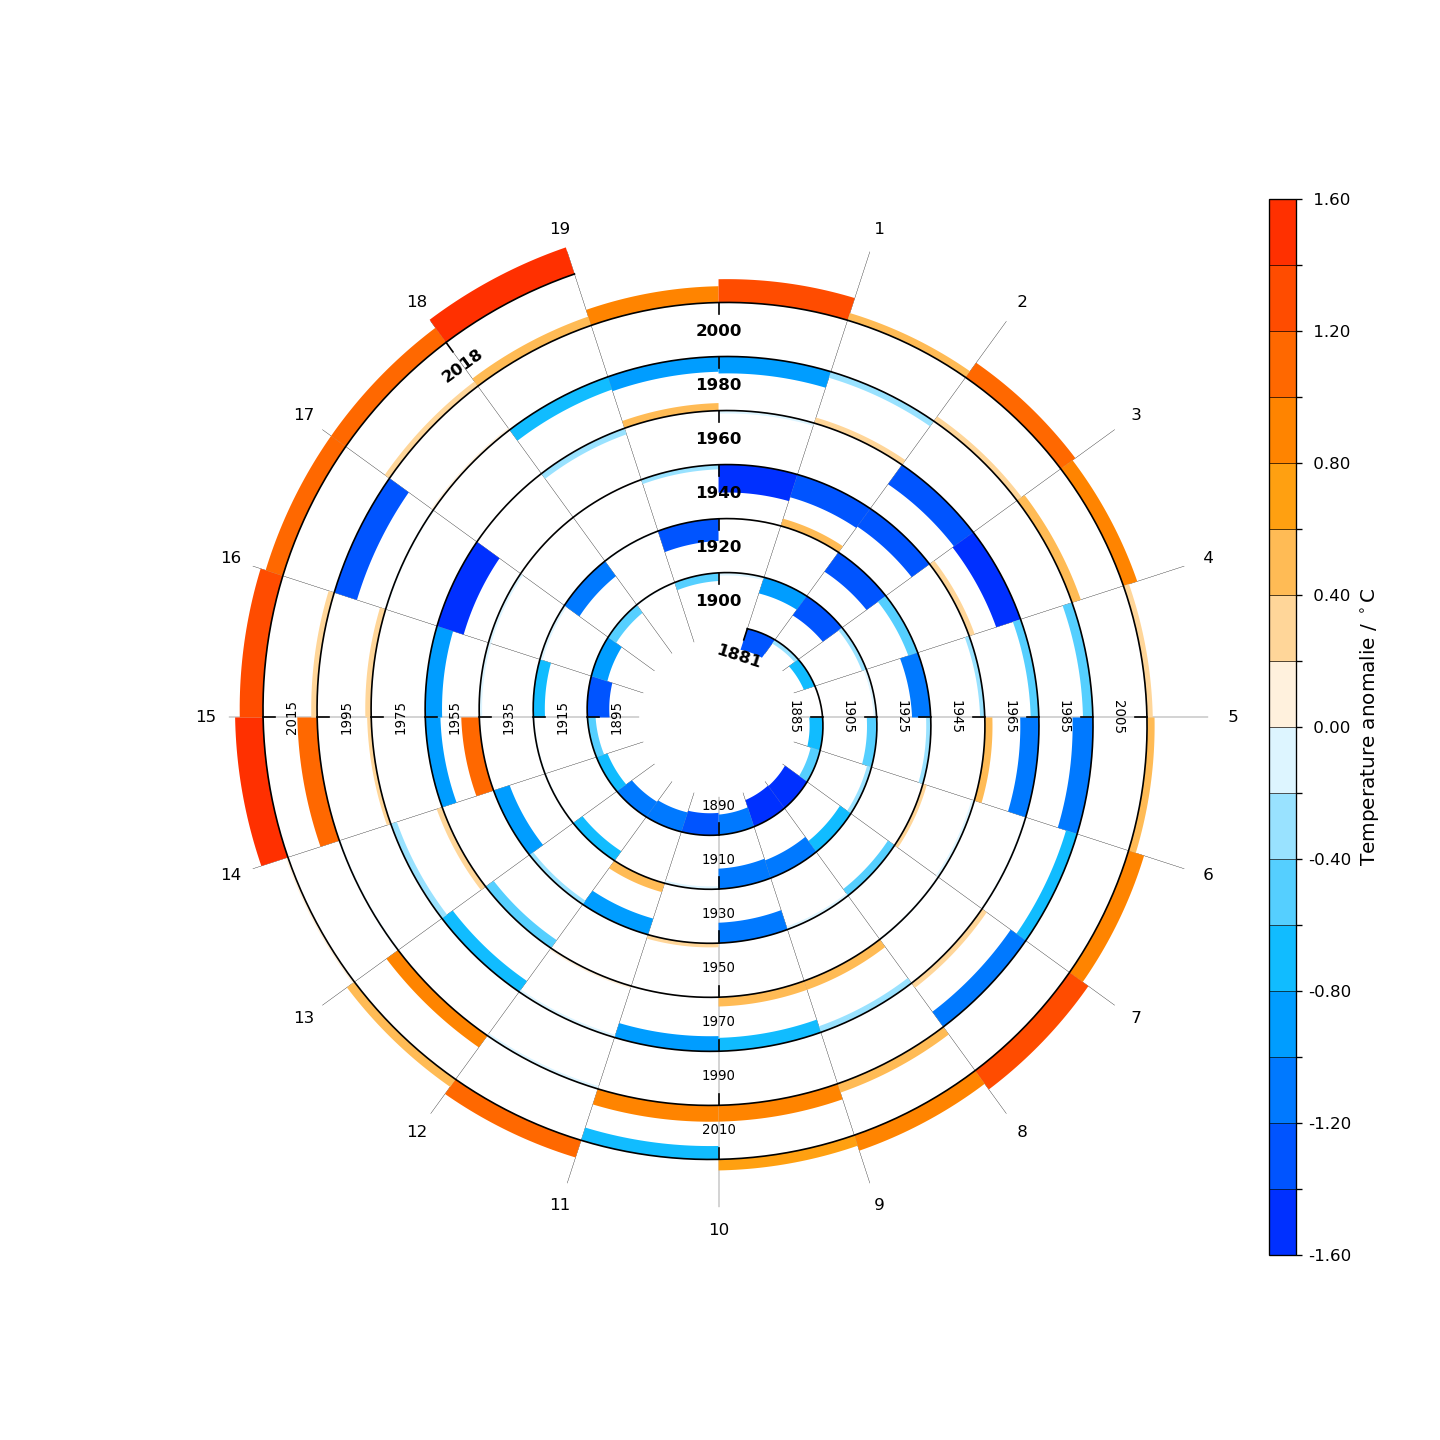

 > save figure: ./anomaly_spiral_barscal_ym.png


In [4]:
cinfo  = dict()
cinfo['cmin']   =-1.5;
cinfo['cmax']   = 1.5;
cinfo['cref']   = 0;
cinfo['cnum']   = 15;
cinfo['cstr']   = 'blue2red'
cinfo['cmap'], cinfo['clevel'], dum = tpv.colormap_c2c(cinfo['cmin'], cinfo['cmax'], cinfo['cref'], cinfo['cnum'], cinfo['cstr'])
#___________________________________________________________________________________________
fig, ax1 = plot_anomalie_spiral(time1, data_anom1, 1, cinfo,
                             rmin=4, rmax=20, drw=1.2, yrpercircl=20, ticklen=0.25, do_barscal=False)
# save figure
sdname = './'
sfname = 'anomaly_spiral'
sfname = sfname + '_ym'
sfname = sfname + '.png'
tpv.do_savefigure(os.path.join(sdname,sfname), fig, dpi=600)

#___________________________________________________________________________________________
fig, ax1 = plot_anomalie_spiral(time1, data_anom1, 1, cinfo, 
                             rmin=4, rmax=20, drw=1.2, yrpercircl=20, ticklen=0.25, do_barscal=True)
# save figure
sdname = './'
sfname = 'anomaly_spiral_barscal'
sfname = sfname + '_ym'
sfname = sfname + '.png'
tpv.do_savefigure(os.path.join(sdname,sfname), fig, dpi=600)

<IPython.core.display.Javascript object>


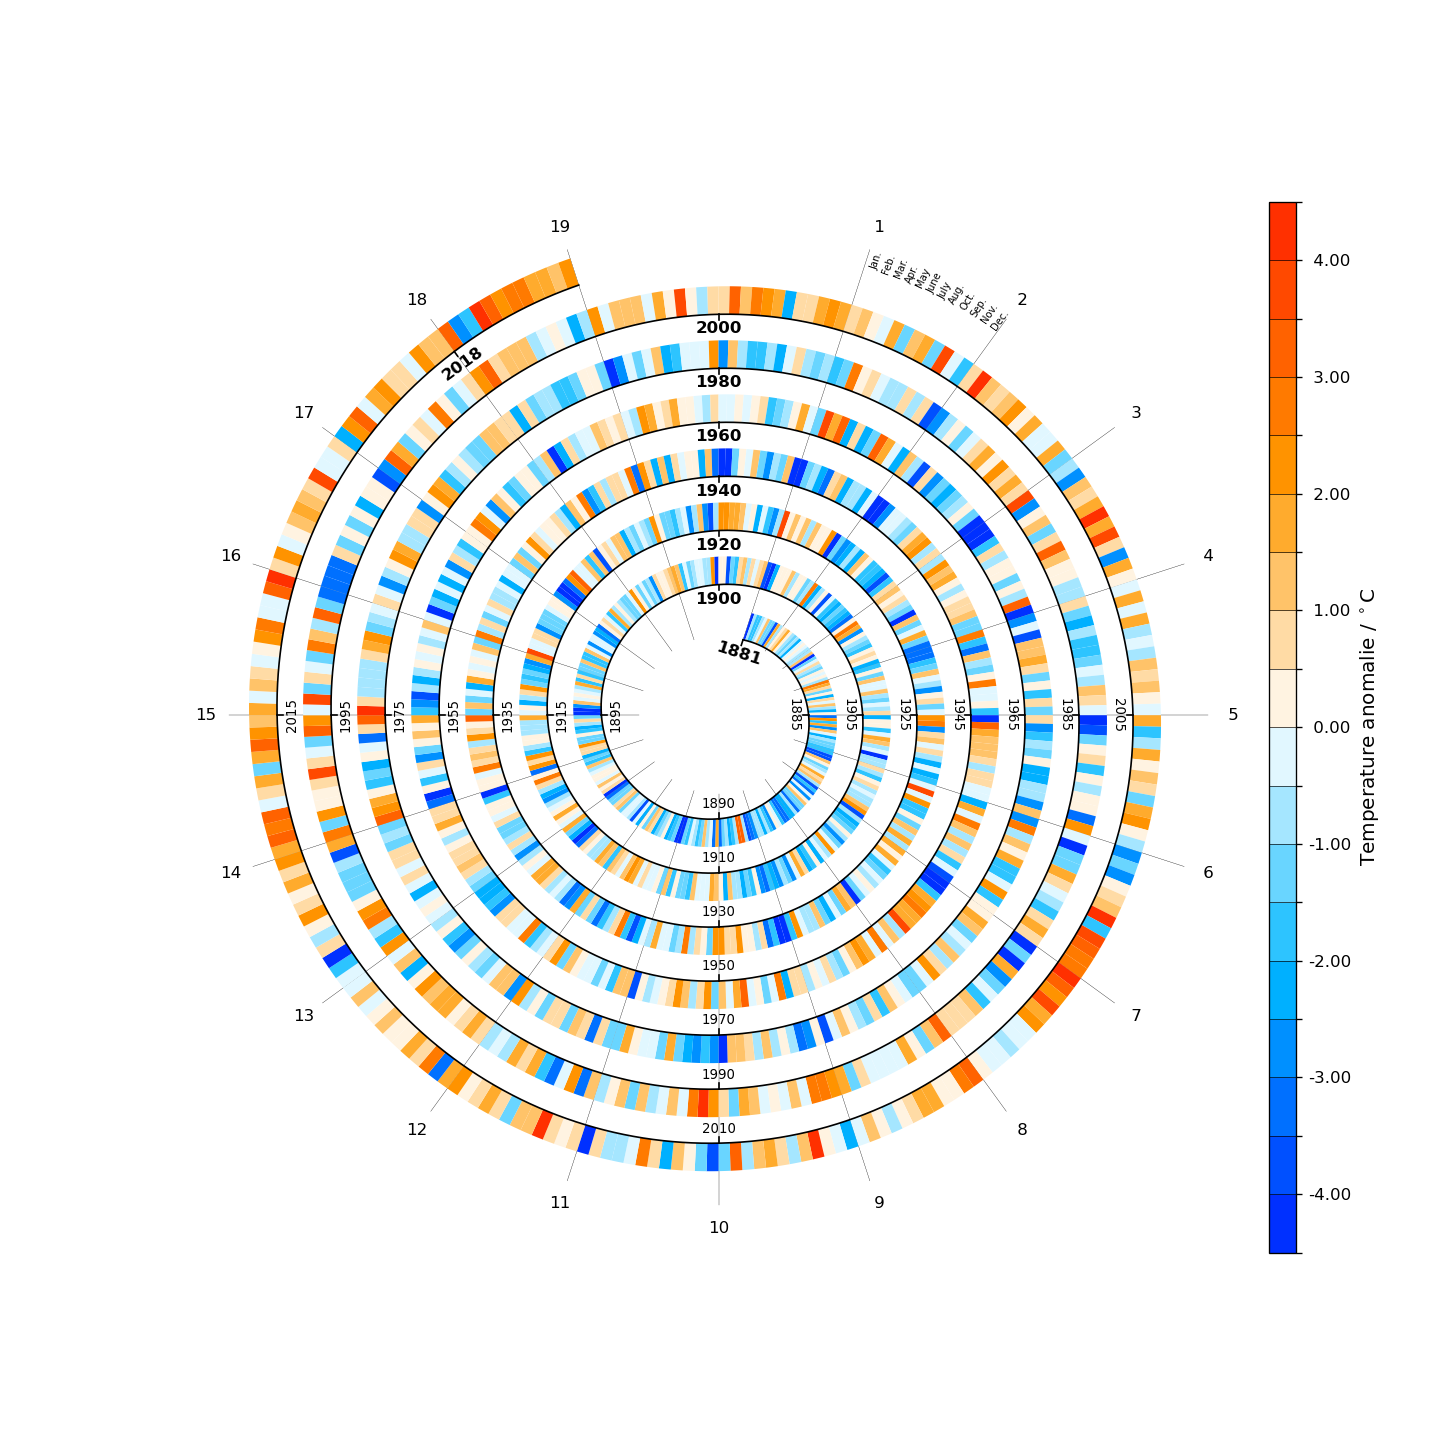

 > save figure: ./anomaly_spiral_mm.png


<IPython.core.display.Javascript object>


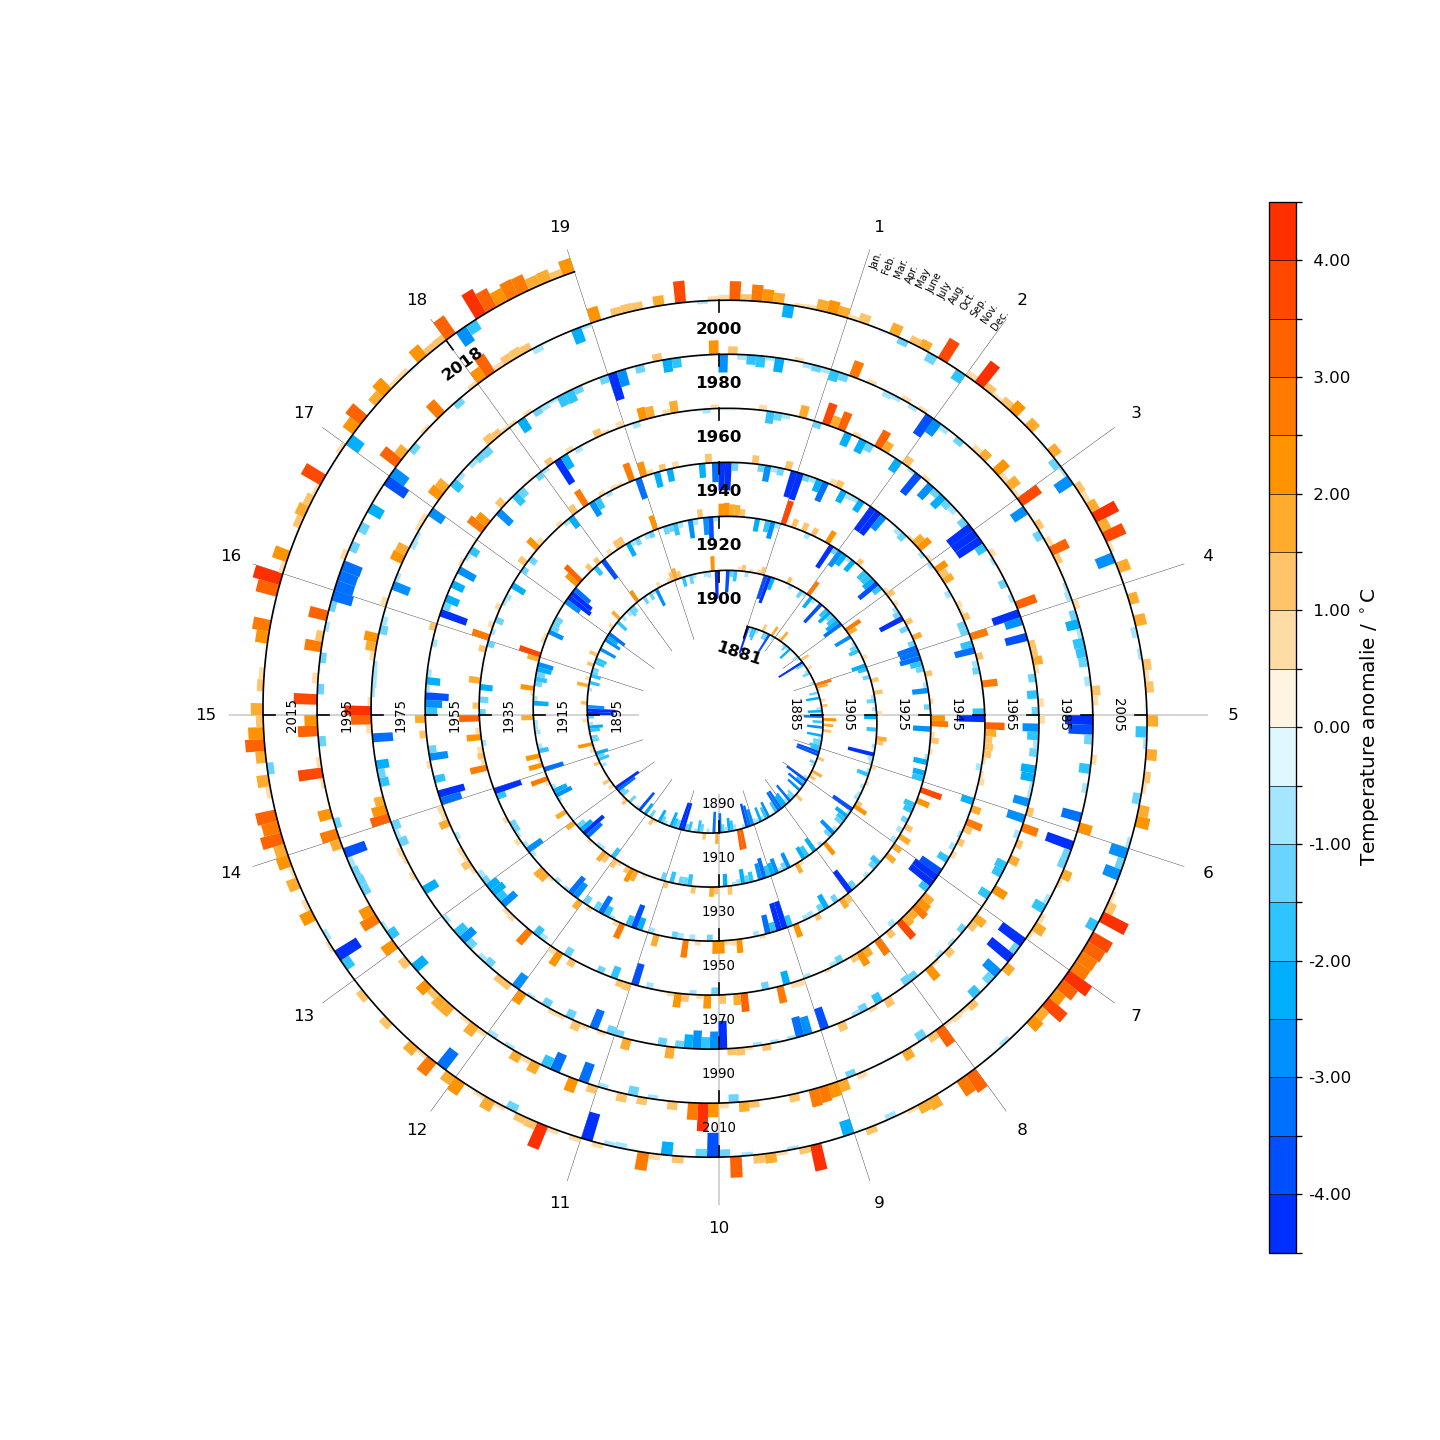

 > save figure: ./anomaly_spiral_barscal_mm.png


In [5]:
cinfo  = dict()
cinfo['cmin']   =-4.5;
cinfo['cmax']   = 4.5;
cinfo['cref']   = 0;
cinfo['cnum']   = 15;
cinfo['cstr']   = 'blue2red'
cinfo['cmap'], cinfo['clevel'], dum = tpv.colormap_c2c(cinfo['cmin'], cinfo['cmax'], cinfo['cref'], cinfo['cnum'], cinfo['cstr'])
#___________________________________________________________________________________________
fig, ax1 = plot_anomalie_spiral(time2, data_anom2, nmon, cinfo,
                             rmin=4, rmax=20, drw=1.2, yrpercircl=20, ticklen=0.25, do_barscal=False)
# save figure
sdname = './'
sfname = 'anomaly_spiral'
sfname = sfname + '_mm'       
sfname = sfname + '.png'
tpv.do_savefigure(os.path.join(sdname,sfname), fig, dpi=600)

#___________________________________________________________________________________________
fig, ax1 = plot_anomalie_spiral(time2, data_anom2, nmon, cinfo, 
                             rmin=4, rmax=20, drw=1.2, yrpercircl=20, ticklen=0.25, do_barscal=True)
# save figure
sdname = './'
sfname = 'anomaly_spiral_barscal'
sfname = sfname + '_mm'       
sfname = sfname + '.png'
tpv.do_savefigure(os.path.join(sdname,sfname), fig, dpi=600)
# 